Here we verify that the algorithm used for dead time filtering is behaving as expected.

We also compare the results with the algorithm for paralyzable dead time, for reference.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

mpl.rcParams['font.size'] = 18.0
mpl.rcParams['xtick.labelsize'] = 18.0
mpl.rcParams['ytick.labelsize'] = 18.0
mpl.rcParams['axes.labelsize'] = 18.0
mpl.rcParams['axes.labelsize'] = 18.0

from hendrics.fake import filter_for_deadtime

import numpy as np
np.random.seed(1209432)

## Non-paralyzable dead time

In [2]:
rate = 1000  # ct/s
length = 1000
events = np.random.uniform(0, length, rate * length)
events = np.sort(events)
deadtime = 2.5e-3
events_dt = filter_for_deadtime(events, deadtime)

diff = np.diff(events)
diff_dt = np.diff(events_dt)

<IPython.core.display.Javascript object>


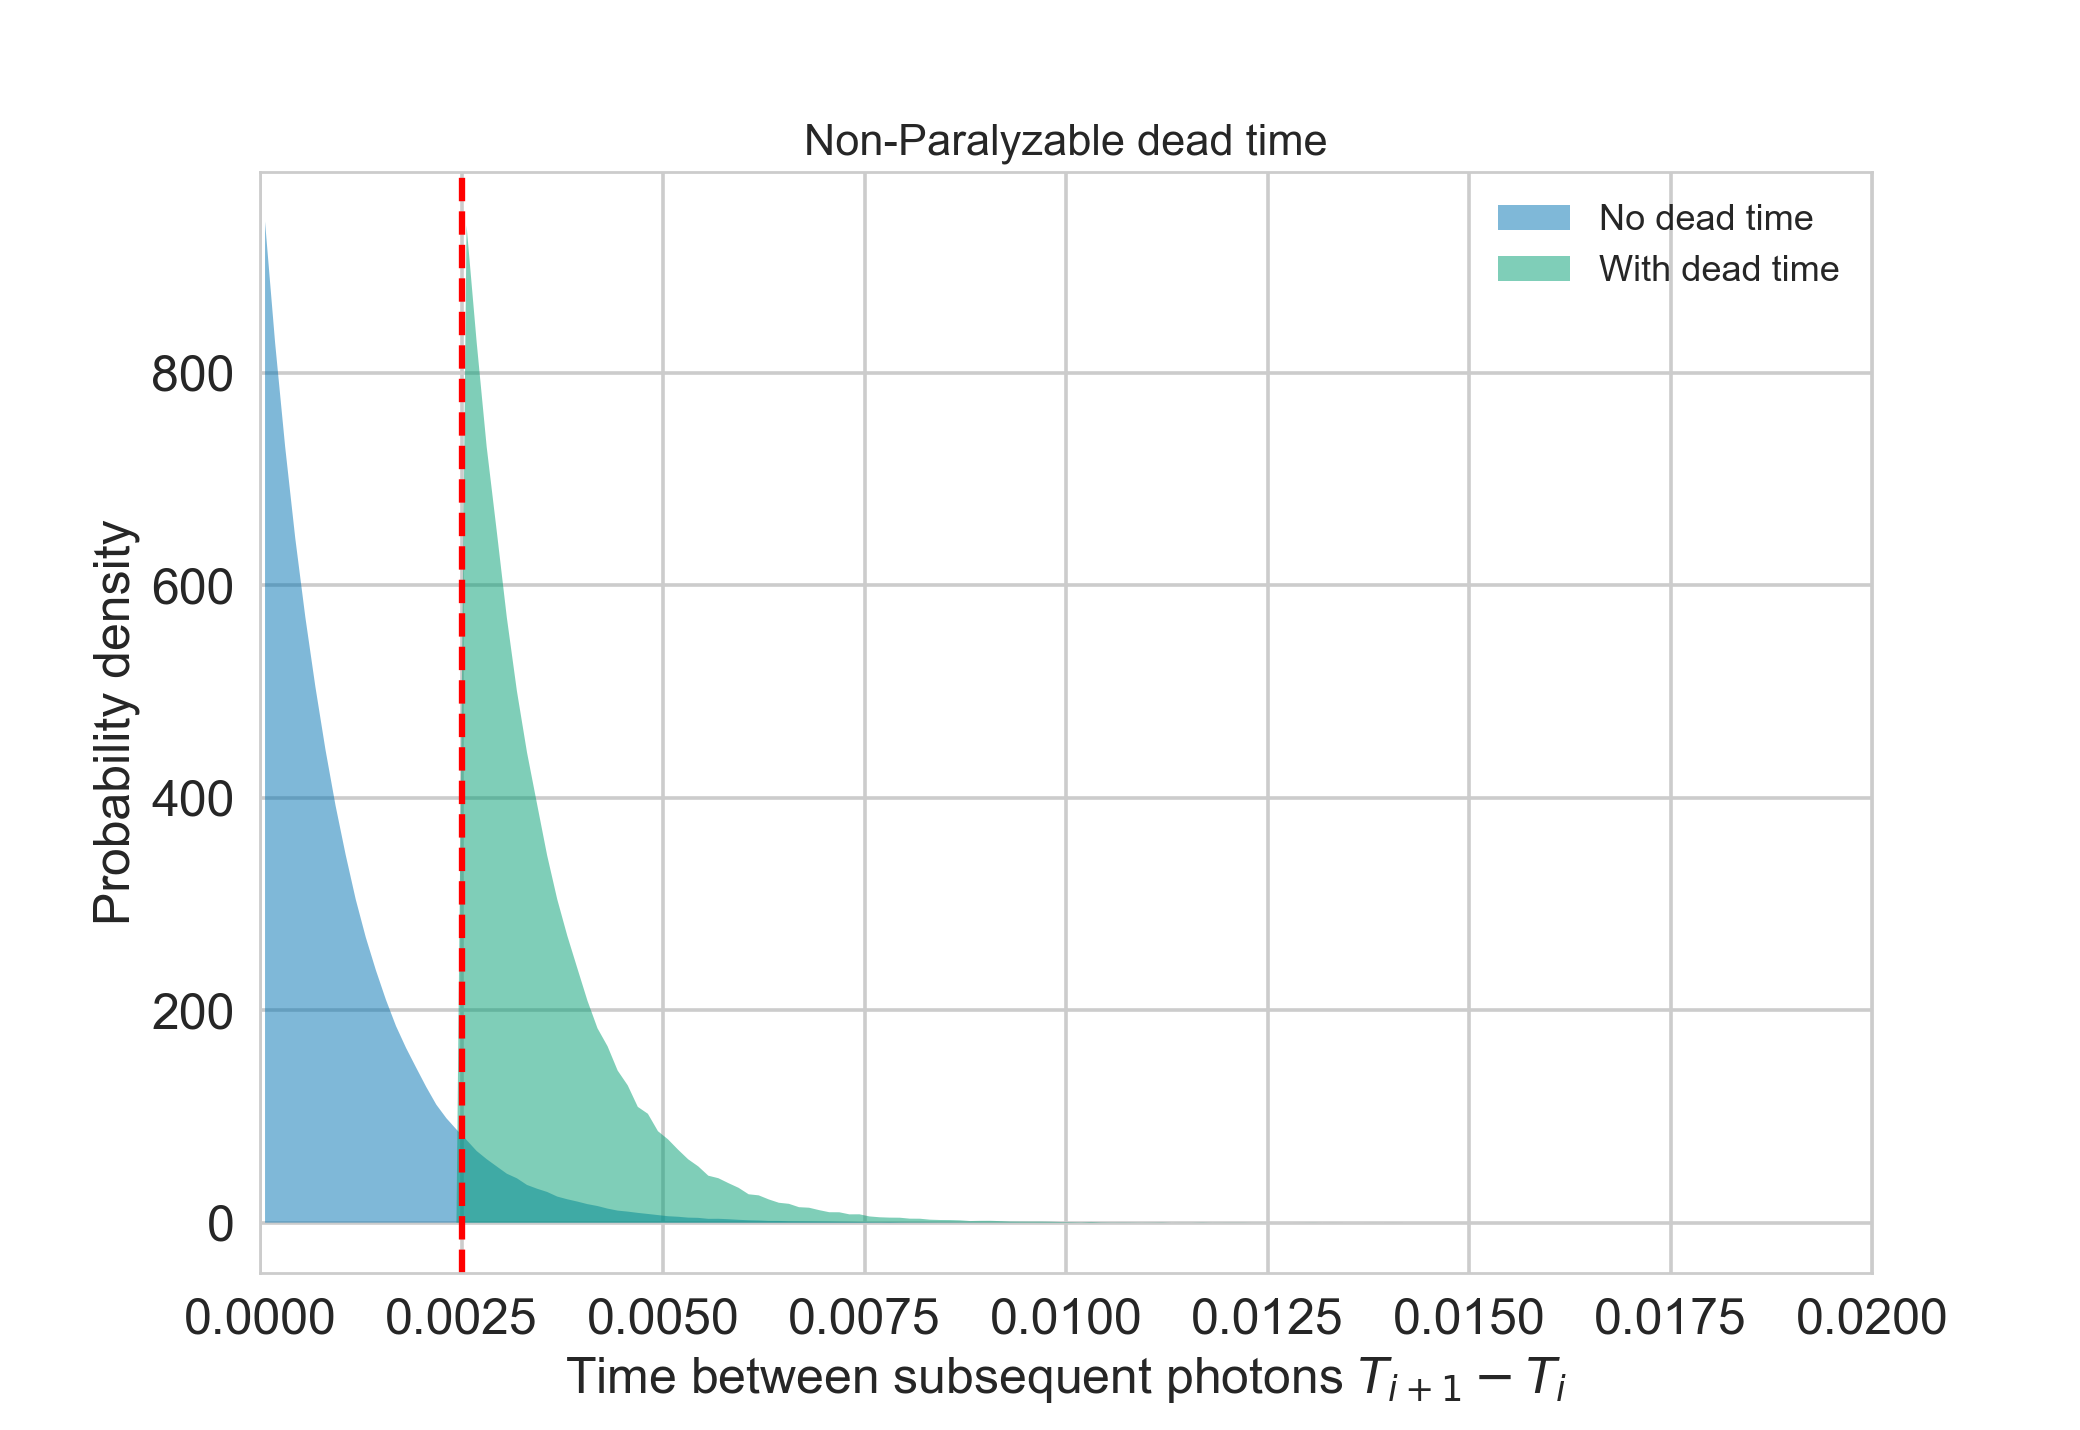

In [3]:
dt = 2.5e-3/20  # an exact fraction of deadtime
bins = np.arange(0, np.max(diff), dt)
hist = np.histogram(diff, bins=bins, density=True)[0]
hist_dt = np.histogram(diff_dt, bins=bins, density=True)[0]

bins_mean = bins[:-1] + dt/2
plt.figure()
plt.title('Non-Paralyzable dead time')

plt.fill_between(bins_mean, 0, hist, alpha=0.5, label='No dead time');
plt.fill_between(bins_mean, 0, hist_dt, alpha=0.5, label='With dead time');

plt.xlim([0, 0.02]);
# plt.ylim([0, 100]);

plt.axvline(2.5e-3, color='r', ls='--')
plt.xlabel(r'Time between subsequent photons $T_{i+1} - T_{i}$')
plt.ylabel('Probability density')

plt.legend();

Exactly as expected, the output distribution of the distance between the events follows an exponential distribution cut at 2.5 ms.

The measured rate is expected to go as 
$$r_{det} = \frac{r_{in}}{1 + r_{in}\tau_d}$$ 
(Zhang+95, eq. 29). Let's check it.

<IPython.core.display.Javascript object>


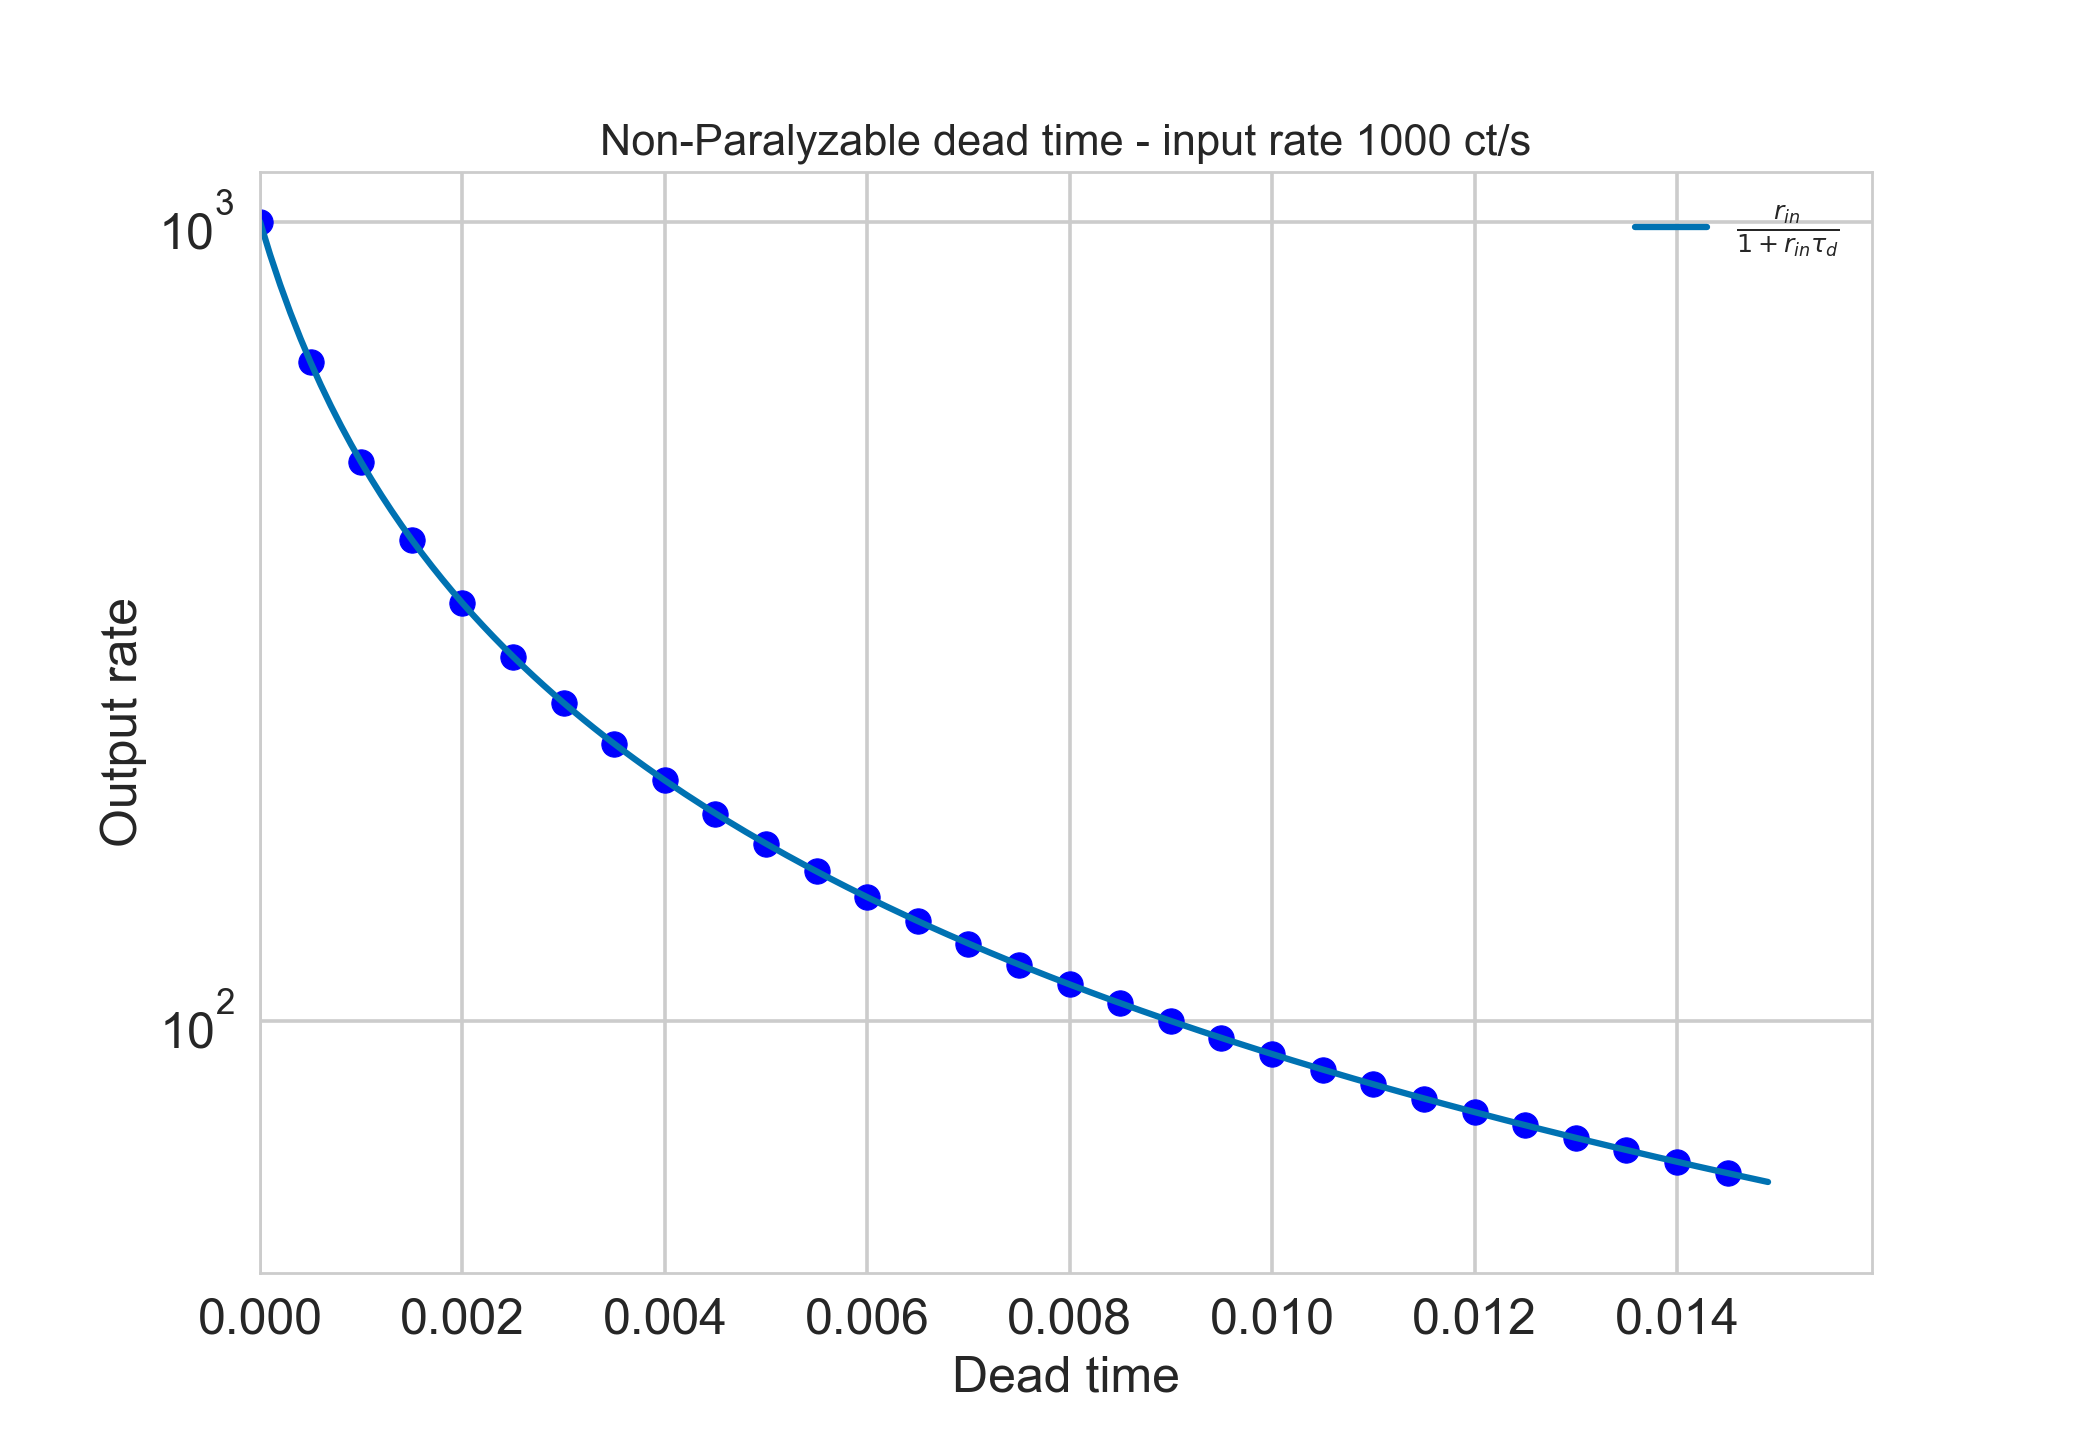

In [4]:
plt.figure()
plt.title('Non-Paralyzable dead time - input rate {} ct/s'.format(rate))

deadtimes = np.arange(0, 0.015, 0.0005)
deadtimes_plot = np.arange(0, 0.015, 0.0001)

for d in deadtimes:
    events_dt = filter_for_deadtime(events, d)
    new_rate = len(events_dt) / length
    plt.scatter(d, new_rate, color='b')

plt.plot(deadtimes_plot, rate / (1 + rate * deadtimes_plot), 
         label=r'$\frac{r_{in}}{1 + r_{in}\tau_d}$')
plt.xlim([0, None])
plt.xlabel('Dead time')
plt.ylabel('Output rate')
plt.semilogy()
plt.legend()

## Paralyzable dead time

In [5]:
rate = 1000  # ct/s
length = 1000
events = np.random.uniform(0, length, rate * length)

events = np.sort(events)

events_dt = filter_for_deadtime(events, 2.5e-3, paralyzable=True)

diff = np.diff(events)
diff_dt = np.diff(events_dt)

<IPython.core.display.Javascript object>


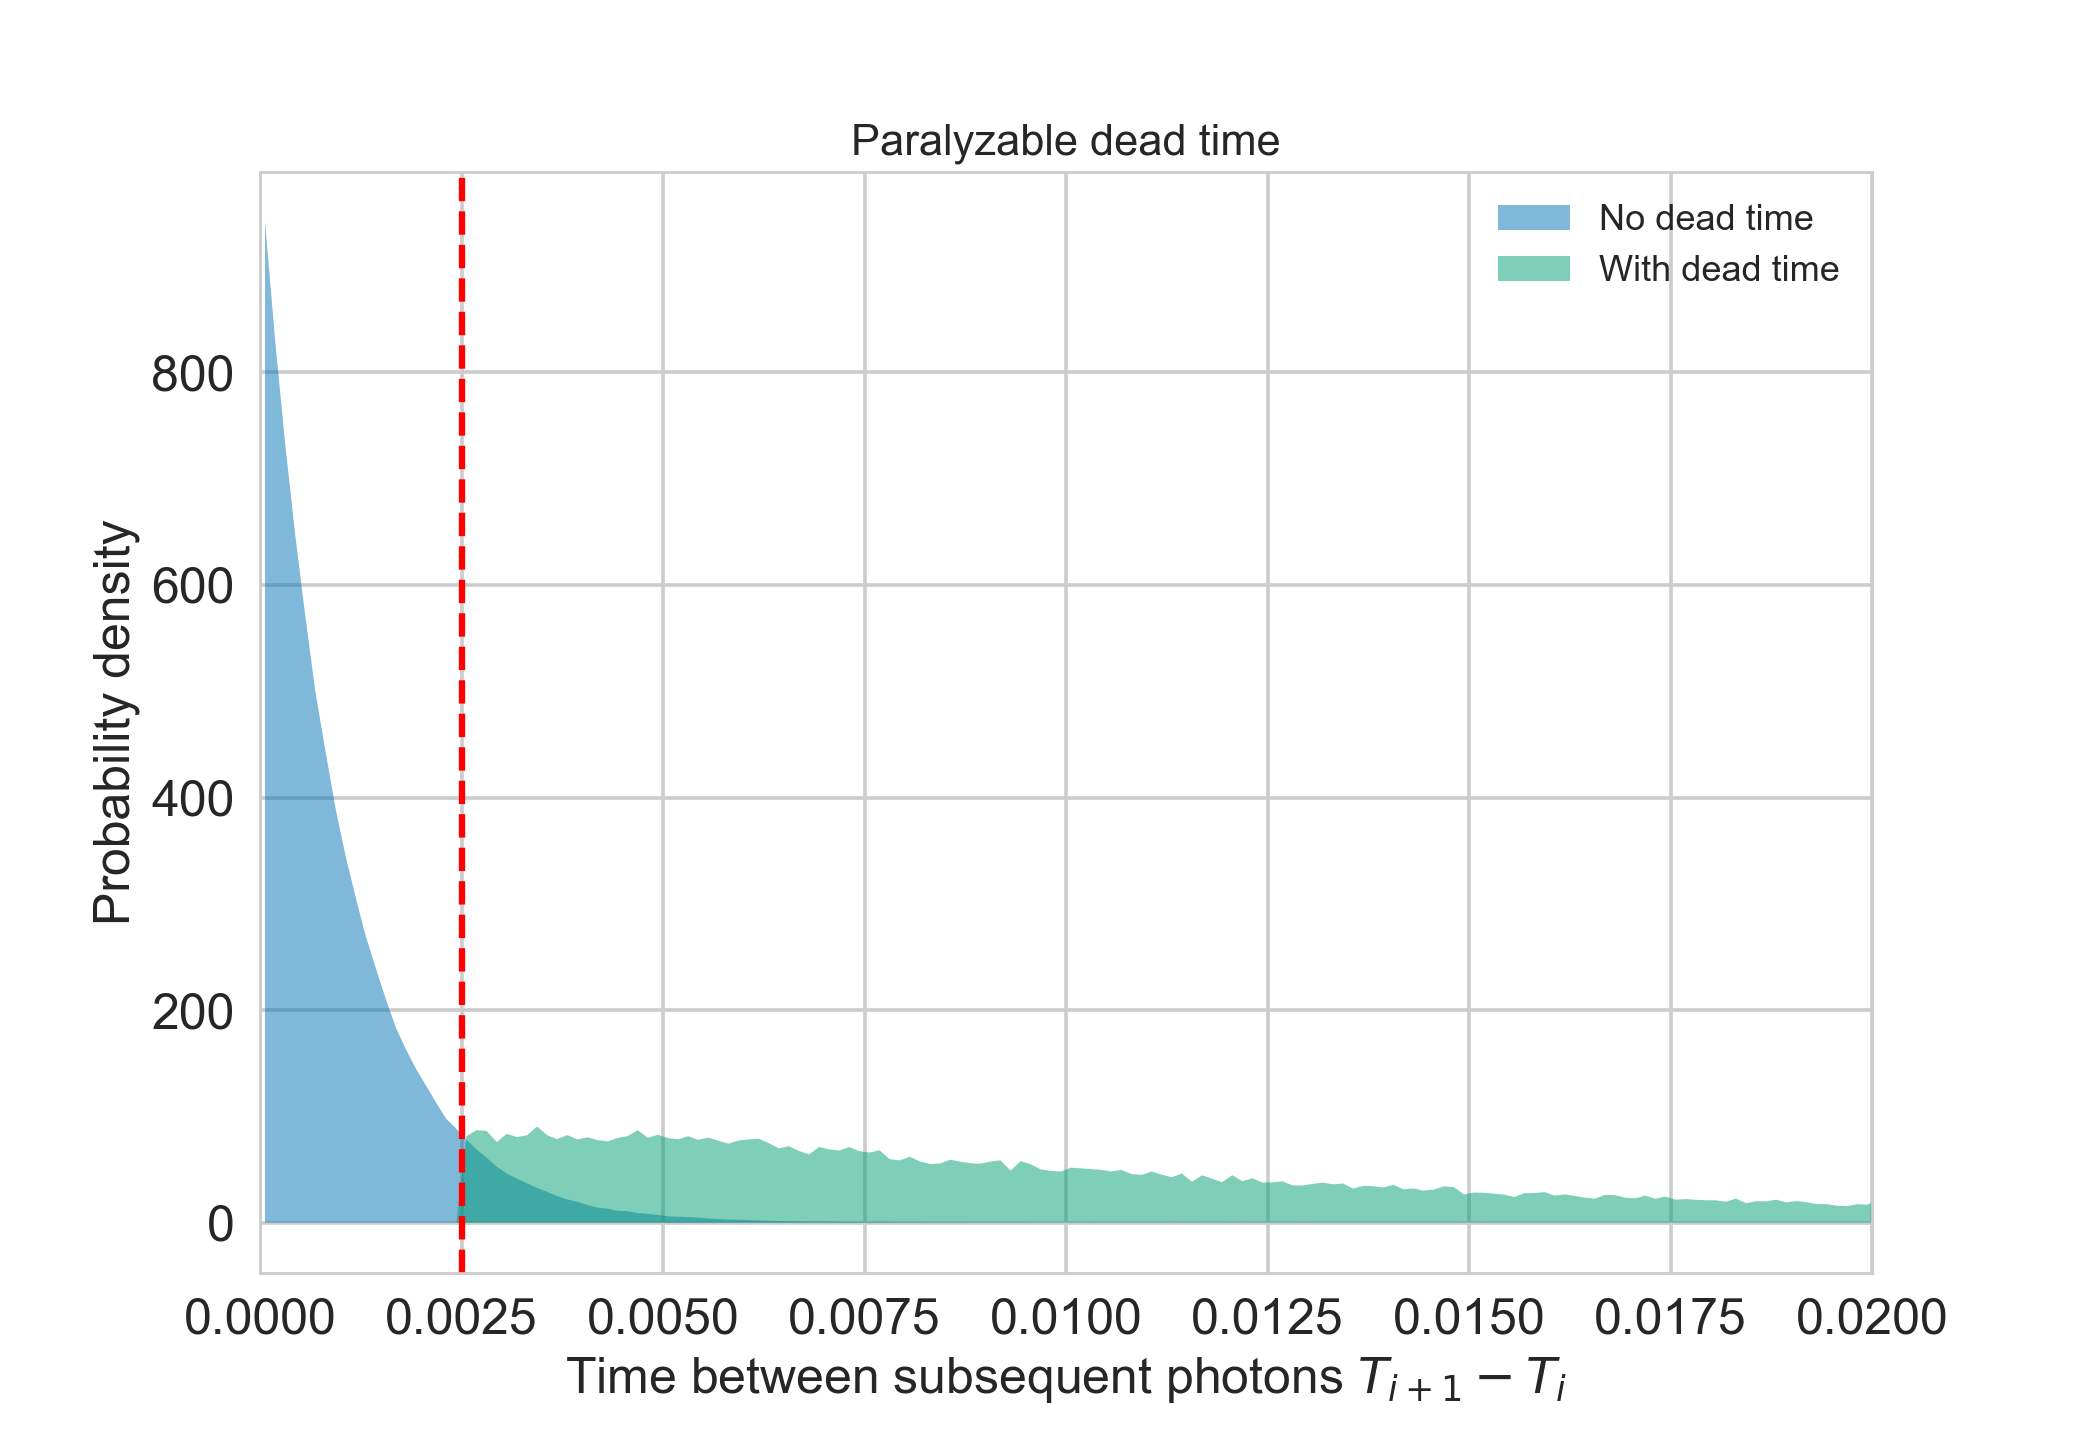

In [6]:
dt = 2.5e-3/20  # an exact fraction of deadtime
bins = np.arange(0, np.max(diff_dt), dt)
hist = np.histogram(diff, bins=bins, density=True)[0]
hist_dt = np.histogram(diff_dt, bins=bins, density=True)[0]

bins_mean = bins[:-1] + dt/2
plt.figure()
plt.title('Paralyzable dead time')
plt.fill_between(bins_mean, 0, hist, alpha=0.5, label='No dead time');
plt.fill_between(bins_mean, 0, hist_dt, alpha=0.5, label='With dead time');
plt.xlim([0, 0.02]);
# plt.ylim([0, 100]);

plt.axvline(2.5e-3, color='r', ls='--')
plt.xlabel(r'Time between subsequent photons $T_{i+1} - T_{i}$')
plt.ylabel('Probability density')

plt.legend();

Non-paralyzable dead time has a distribution for the time between consecutive counts that plateaus between $\tau_d$ and $2\tau_d$, then decreases. The exact form is complicated (e.g. )

The measured rate is expected to go as 
$$r_{det} = r_{in}e^{-r_{in}\tau_d}$$
(Zhang+95, eq. 16). Let's check it.

<IPython.core.display.Javascript object>


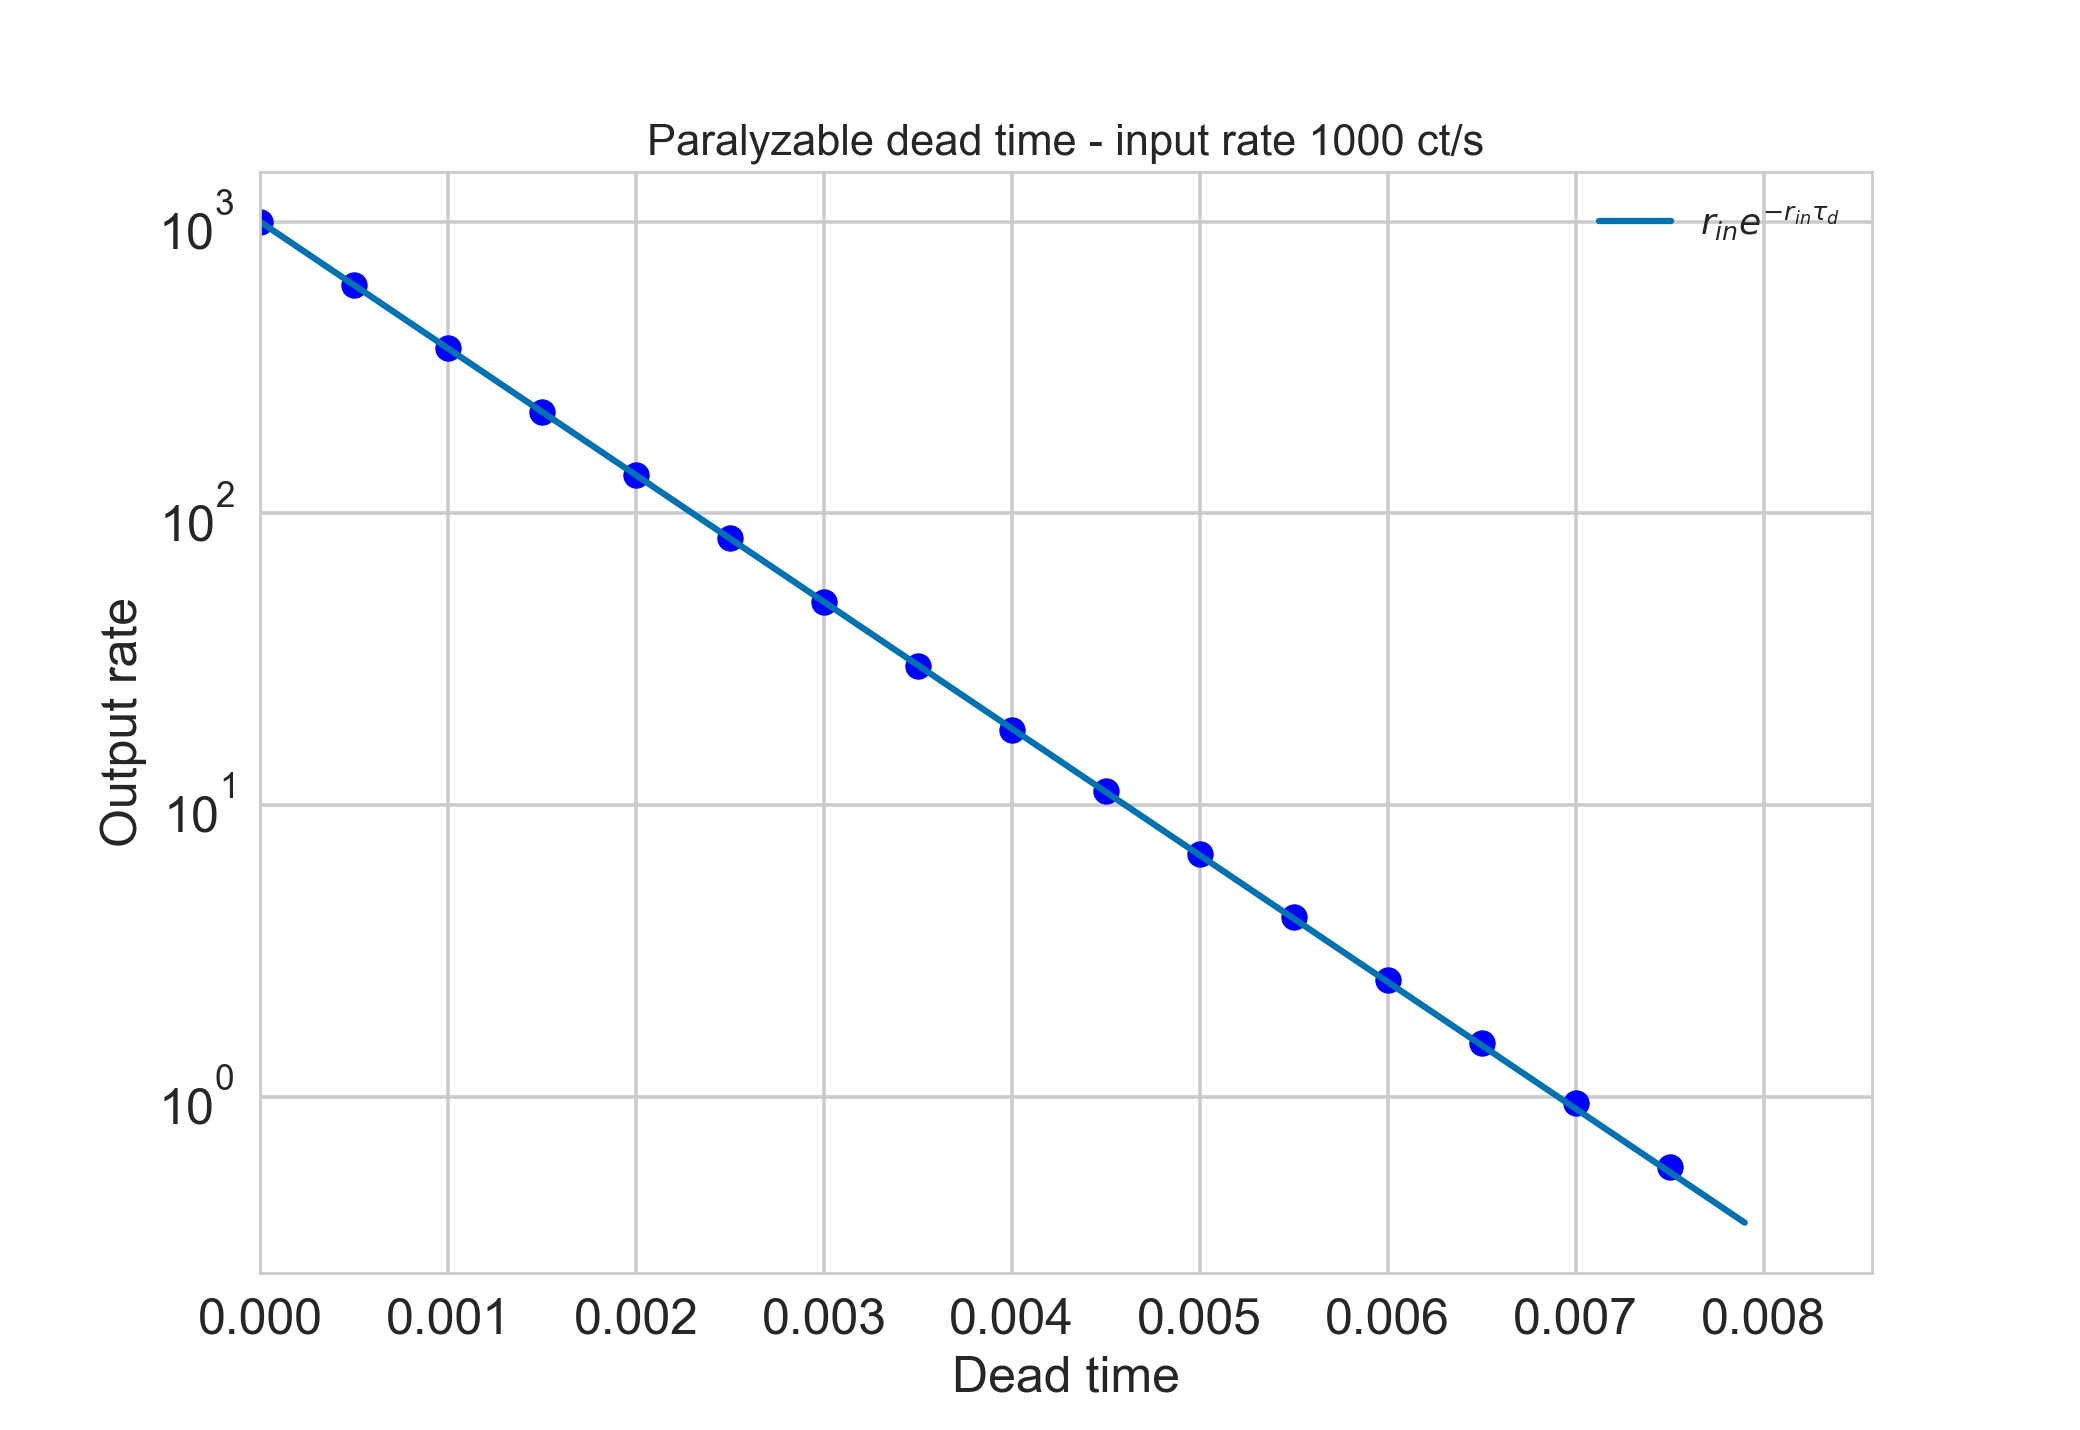

In [7]:
plt.figure()
plt.title('Paralyzable dead time - input rate {} ct/s'.format(rate))

deadtimes = np.arange(0, 0.008, 0.0005)
deadtimes_plot = np.arange(0, 0.008, 0.0001)

for d in deadtimes:
    events_dt = filter_for_deadtime(events, d, paralyzable=True)
    new_rate = len(events_dt) / length
    plt.scatter(d, new_rate, color='b')

plt.plot(deadtimes_plot, rate * np.exp(-rate * deadtimes_plot), 
         label=r'$r_{in}e^{-r_{in}\tau_d}$')
plt.xlim([0, None])
plt.xlabel('Dead time')
plt.ylabel('Output rate')
plt.semilogy()
plt.legend()

Perfect.